In [163]:
# ! pip install yfinance

In [164]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.layers import Dropout

import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf

In [165]:
df = yf.download("BABA", start = "2015-01-01", end = "2023-03-01")
data = df.filter(['Close'])

[*********************100%***********************]  1 of 1 completed


In [166]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,104.239998,104.720001,102.519997,103.599998,103.599998,12303400
2015-01-05,102.760002,103.019997,99.900002,101.000000,101.000000,18337000
2015-01-06,101.250000,103.849998,100.110001,103.320000,103.320000,15720400
2015-01-07,104.589996,104.739998,102.029999,102.129997,102.129997,11052200
2015-01-08,102.949997,105.339996,102.680000,105.029999,105.029999,12942100
...,...,...,...,...,...,...
2023-02-22,95.574997,95.889999,93.555000,94.779999,94.779999,24484000
2023-02-23,100.099998,100.470001,92.129997,94.160004,94.160004,40482900
2023-02-24,90.070000,91.680000,88.029999,89.000000,89.000000,36174500


In [167]:
data

,Close
Date,
2015-01-02,103.599998
2015-01-05,101.000000
2015-01-06,103.320000
2015-01-07,102.129997
2015-01-08,105.029999
...,...
2023-02-22,94.779999
2023-02-23,94.160004
2023-02-24,89.000000


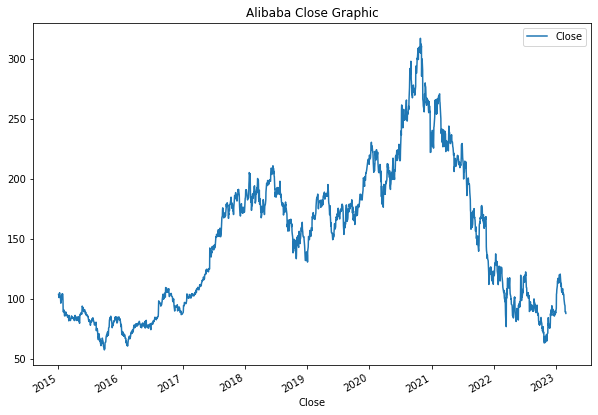

In [168]:
data.plot(figsize=(10,7))
plt.xlabel('Close')
plt.title('Alibaba Close Graphic');

In [169]:
timesteps = data.index.to_numpy()
prices = data["Close"].to_numpy()

timesteps[:10], prices[:10]

(array(['2015-01-02T00:00:00.000000000', '2015-01-05T00:00:00.000000000',
        '2015-01-06T00:00:00.000000000', '2015-01-07T00:00:00.000000000',
        '2015-01-08T00:00:00.000000000', '2015-01-09T00:00:00.000000000',
        '2015-01-12T00:00:00.000000000', '2015-01-13T00:00:00.000000000',
        '2015-01-14T00:00:00.000000000', '2015-01-15T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([103.59999847, 101.        , 103.31999969, 102.12999725,
        105.02999878, 103.01999664, 101.62000275, 100.76999664,
         99.58000183,  96.30999756]))

In [170]:
int(len(data)*0.8)

1642

In [171]:
X_train, y_train = timesteps[:1642], prices[:1642]
X_test, y_test = timesteps[1642:], prices[1642:]

In [172]:
X_train.shape, y_train.shape

((1642,), (1642,))

In [173]:
X_test.shape, y_test.shape

((411,), (411,))

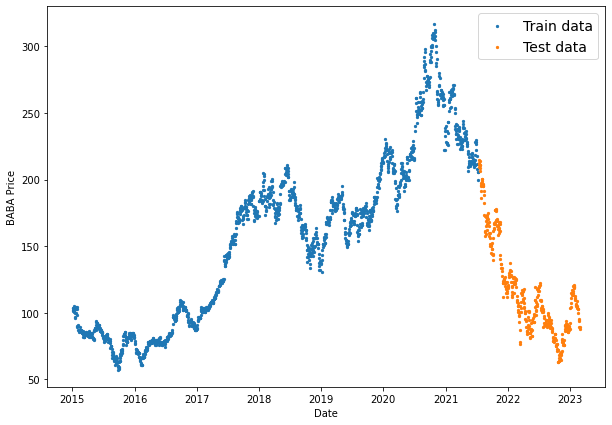

In [174]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BABA Price")
plt.legend(fontsize=14)
plt.show();

In [175]:
X_train[:10], y_train[:10]

(array(['2015-01-02T00:00:00.000000000', '2015-01-05T00:00:00.000000000',
        '2015-01-06T00:00:00.000000000', '2015-01-07T00:00:00.000000000',
        '2015-01-08T00:00:00.000000000', '2015-01-09T00:00:00.000000000',
        '2015-01-12T00:00:00.000000000', '2015-01-13T00:00:00.000000000',
        '2015-01-14T00:00:00.000000000', '2015-01-15T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([103.59999847, 101.        , 103.31999969, 102.12999725,
        105.02999878, 103.01999664, 101.62000275, 100.76999664,
         99.58000183,  96.30999756]))

In [176]:
HORIZON = 1 
WINDOW_SIZE = 7

In [177]:
window_step = np.expand_dims(np.arange(WINDOW_SIZE+HORIZON), axis=0)

In [178]:
window_step

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [179]:
window_indexes = window_step + np.expand_dims(np.arange(len(y_train)-(WINDOW_SIZE+HORIZON-1)), axis=0).T

In [180]:
window_indexes

array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [1632, 1633, 1634, ..., 1637, 1638, 1639],
       [1633, 1634, 1635, ..., 1638, 1639, 1640],
       [1634, 1635, 1636, ..., 1639, 1640, 1641]])

In [181]:
windowed_array = y_train[window_indexes]
windowed_array

array([[103.59999847, 101.        , 103.31999969, ..., 103.01999664,
        101.62000275, 100.76999664],
       [101.        , 103.31999969, 102.12999725, ..., 101.62000275,
        100.76999664,  99.58000183],
       [103.31999969, 102.12999725, 105.02999878, ..., 100.76999664,
         99.58000183,  96.30999756],
       ...,
       [228.58999634, 229.44000244, 226.77999878, ..., 211.6000061 ,
        208.        , 199.8500061 ],
       [229.44000244, 226.77999878, 221.86999512, ..., 208.        ,
        199.8500061 , 205.94000244],
       [226.77999878, 221.86999512, 217.75      , ..., 199.8500061 ,
        205.94000244, 205.47999573]])

In [182]:
train_window = []
train_label = []

for i in windowed_array:
  train_window.append(i[:7])
  train_label.append(i[-1])

In [183]:
train_window[0], train_label[0]

(array([103.59999847, 101.        , 103.31999969, 102.12999725,
        105.02999878, 103.01999664, 101.62000275]), 100.7699966430664)

In [184]:
pd.DataFrame(train_window, train_label)

,0,1,2,3,4,5,6
100.769997,103.599998,101.000000,103.320000,102.129997,105.029999,103.019997,101.620003
99.580002,101.000000,103.320000,102.129997,105.029999,103.019997,101.620003,100.769997
96.309998,103.320000,102.129997,105.029999,103.019997,101.620003,100.769997,99.580002
96.889999,102.129997,105.029999,103.019997,101.620003,100.769997,99.580002,96.309998
100.040001,105.029999,103.019997,101.620003,100.769997,99.580002,96.309998,96.889999
...,...,...,...,...,...,...,...
211.600006,218.380005,228.500000,228.589996,229.440002,226.779999,221.869995,217.750000
208.000000,228.500000,228.589996,229.440002,226.779999,221.869995,217.750000,211.600006
199.850006,228.589996,229.440002,226.779999,221.869995,217.750000,211.600006,208.000000
205.940002,229.440002,226.779999,221.869995,217.750000,211.600006,208.000000,199.850006


In [185]:
for i in range(3):
  print(f"Window: {train_window[i]} -> Label: {train_label[i]}")

Window: [103.59999847 101.         103.31999969 102.12999725 105.02999878
 103.01999664 101.62000275] -> Label: 100.7699966430664
Window: [101.         103.31999969 102.12999725 105.02999878 103.01999664
 101.62000275 100.76999664] -> Label: 99.58000183105469
Window: [103.31999969 102.12999725 105.02999878 103.01999664 101.62000275
 100.76999664  99.58000183] -> Label: 96.30999755859375


In [186]:
int(1635*0.8)

1308

In [187]:
train_windows = train_window[:1308]
train_labels = train_label[:1308]
test_windows = train_window[1308:]
test_labels = train_label[1308:]

In [188]:
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(1308, 1308, 327, 327)

In [189]:
train_windows[1]

array([101.        , 103.31999969, 102.12999725, 105.02999878,
       103.01999664, 101.62000275, 100.76999664])

In [190]:
train_labels[1]

99.58000183105469

In [191]:
test_windows[1]

array([184.80999756, 180.        , 180.88000488, 181.30000305,
       176.33999634, 185.75      , 188.55999756])

In [192]:
test_labels[1]

195.32000732421875

In [193]:
train_windows = np.asarray(train_windows)
train_labels = np.asarray(train_labels)
test_windows = np.asarray(test_windows)
test_labels = np.asarray(test_labels)

In [194]:
train_windows.shape, train_labels.shape, test_windows.shape, test_labels.shape

((1308, 7), (1308,), (327, 7), (327,))

In [195]:
  tf.random.set_seed(42)

  model = tf.keras.Sequential([
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dense(HORIZON, activation='linear')
  ])

model.compile(loss=tf.keras.losses.MAE,
              optimizer= tf.keras.optimizers.Adam(),
              metrics=['mae'])

history = model.fit(train_windows,train_labels,
                    epochs=50,
                    verbose=1,
                    batch_size=128,
                    validation_data=(test_windows,test_labels))

Epoch 1/50
11/11 [==============================] - 1s 20ms/step - loss: 21.1881 - mae: 21.1881 - val_loss: 23.8443 - val_mae: 23.8443
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 7.5661 - mae: 7.5661 - val_loss: 8.4789 - val_mae: 8.4789
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 4.9752 - mae: 4.9752 - val_loss: 8.9099 - val_mae: 8.9099
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 4.2081 - mae: 4.2081 - val_loss: 7.7408 - val_mae: 7.7408
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 3.9529 - mae: 3.9529 - val_loss: 7.8357 - val_mae: 7.8357
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 3.7818 - mae: 3.7818 - val_loss: 7.7371 - val_mae: 7.7371
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 3.7688 - mae: 3.7688 - val_loss: 7.7310 - val_mae: 7.7310
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 3.8405 - mae:

In [196]:
model.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 3ms/step - loss: 5.7656 - mae: 5.7656


[5.765577793121338, 5.765577793121338]

In [197]:
model_pred = model.predict(test_windows)

11/11 [==============================] - 0s 3ms/step


In [198]:
model_pred = tf.squeeze(model_pred,axis=1)

In [199]:
model_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([184.83405, 186.3782 , 190.29663, 190.2775 , 192.39493, 194.23016,
       191.2185 , 192.62282, 191.3948 , 194.13354], dtype=float32)>

In [200]:
model_pred = np.asarray(model_pred)

In [201]:
test_labels.shape, model_pred.shape

((327,), (327,))

In [202]:
len(model_pred), model_pred[:10]

(327, array([184.83405, 186.3782 , 190.29663, 190.2775 , 192.39493, 194.23016,
        191.2185 , 192.62282, 191.3948 , 194.13354], dtype=float32))

In [203]:
y_true = tf.cast(test_labels, dtype=tf.float32)
y_pred = tf.cast(model_pred, dtype=tf.float32)

mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
rmse = tf.sqrt(mse)
mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  
print( {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()})

{'mae': 5.7655764, 'mse': 60.56114, 'rmse': 7.7821035, 'mape': 2.4042113}


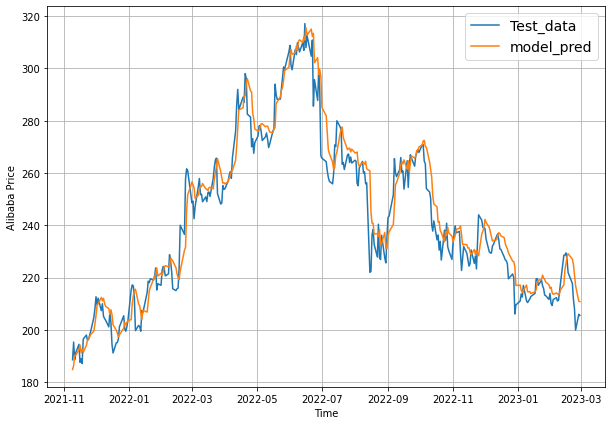

In [204]:
timesteps=X_test[-len(test_windows):]

plt.figure(figsize=(10, 7))
plt.xlabel("Time")
plt.ylabel("Alibaba Price")
plt.grid(True)
plt.plot(timesteps, test_labels, label="Test_data")
plt.plot(timesteps, model_pred,  label="model_pred")
plt.legend(fontsize=14);